In [2]:
%load_ext autoreload
%autoreload 2
#import plum
#plum.autoreload.activate()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import json

from functools import partial, reduce

In [40]:
from cx import CX

In [4]:
# Added to silence some warnings.
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp

import flax
import optax

/opt/anaconda3/envs/q_embedding_new/lib/python3.8/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [5]:
import pennylane as qml
import netket as nk
from netket.operator.spin import sigmax,sigmaz

In [6]:
np.set_printoptions(precision=4)
np.set_printoptions(linewidth=250)

In [8]:
from utils             import *
from hamiltonians      import *
from quantum_circuits  import *
from classic_models    import *

## Ising - system and Hamiltonian

In [13]:
phys_qubits       = 3
n_classical_spins = 4

ancilla_qubits    = 1
tot_qubits        = phys_qubits + ancilla_qubits

q_index           = [i for i in range(n_classical_spins//2,n_classical_spins//2+phys_qubits)]
c_index           = [i for i in range(n_classical_spins//2)] + [i for i in range(n_classical_spins//2+phys_qubits, n_classical_spins+phys_qubits)]

device_phys         = qml.device("default.qubit.jax", wires=list(range(phys_qubits)))
device_with_ancilla = qml.device("default.qubit.jax", wires=list(range(phys_qubits))+["a"])

# Define the Hilbert space
hi = nk.hilbert.Spin(s=1 / 2, N=n_classical_spins)

In [14]:
## Define the Hamiltonian

# Ising
hc = -1
hq = -1

j_c      = 0.25
j_q      = 1.0
j_int    = 0.5

h_list   = (n_classical_spins//2)*[hc] + (phys_qubits)*[hq] + (n_classical_spins//2)*[hc]

j_list   = (n_classical_spins//2 -1)*[j_c] + [j_int] + (phys_qubits - 1)*[j_q] + [j_int] +  (n_classical_spins//2 -1)*[j_c]
#h_mixed  = ising_hamiltonian_mixed(tot_spins,j_list,h_list,q_index)
hami_op_list, hami_coeff_list = generate_ising_hami_list(phys_qubits+n_classical_spins,j_list,h_list)

In [15]:
h_mixed = mixed_hami_from_list(hami_op_list,hami_coeff_list,hi,q_index,c_index)

Number of pure  quantum op: 5
Number of pure  classic op: 6
Number of       mixed   op: 2
Number of quantum    group: 2


## Exact energy of the GS 

In [16]:
hi_full = nk.hilbert.Spin(s=1 / 2, N=phys_qubits+n_classical_spins)

In [17]:
## Total Hamiltonian
htot_nk = netket_hami_from_list(hami_op_list,hami_coeff_list,hi_full)

In [18]:
## Ground state energy
E_gs, psi_gs = nk.exact.lanczos_ed(htot_nk, compute_eigenvectors=True)

In [19]:
E_gs[0]

-7.666408476569804

## Circuit

In [20]:
## Total circuit
depth   =  2
my_circ = (circ_pass, circ_classic_RY, partial(circ_RY ,depth))

In [41]:
## Print the circuit
draw_device = qml.device("default.qubit", list(range(phys_qubits))+["a"])

In [49]:
@qml.qnode(draw_device)
def draw_circuit(params,θ_σ,θ_η):
    
    my_circ[1](draw_device, params, θ_σ, θ_η)
    my_circ[2](draw_device,  params)
    
    return qml.state()

In [50]:
draw_circuit(jnp.asarray(list(range(15))),jnp.asarray(list(range(5,7))),None)

Array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j], dtype=complex128)

In [47]:
drawer = qml.draw(draw_circuit)
print(drawer(jnp.asarray(list(range(15))),jnp.asarray(list(range(5,7))),None))

0: ──CX(1.00)─┤  State


## Training 

### Define the classic models

In [24]:
time_seed = int(time.time())
seed      = jax.random.PRNGKey(time_seed)

In [25]:
########## Initialise RBM Spin Machine
ma       = nk.models.RBM(alpha=1, param_dtype=float)
# Random initialization
pars_c     = ma.init(seed, hi.random_state(seed, 1))

## Initialise the sampler 
sa       = nk.sampler.ExactSampler(hi)
sa_state = sa.init_state(ma, pars_c, seed)

In [26]:
########## Sample to angle machine
angles_a = 2  # Number of angles controlled in the circuit
alpha_a  = 2  # Numbers of nodes in the hidden layer of the NN
sta      = Sample_to_angle(alpha=alpha_a, angles=angles_a, param_dtype=float)
pars_a   = sta.init(seed, jnp.array([-1 for  i in range(n_classical_spins)]))

In [27]:
########## Quantum circuit
pars_q = np.random.rand(phys_qubits*(depth+1))

# Put quantum and classical params together
pars_all = flax.core.unfreeze(pars_c)
pars_all['quantum'] = pars_q
pars_all['angles']  = pars_a
pars_all = flax.core.freeze(pars_all)

## Energy and gradient

In [28]:
def e_tot_and_grad_demo(ma, dev, circ, pars, σ, sample_to_angle, h_mixed):
    
    '''
    This function will return the energy  and its gradient

    Args:
        ma:              NetKet classic model
        dev:             pennylane device
        circ:            pennylane circuit
        pars:            parameters of the model
        σ:               classic samples
        sample_to_angle: function to convert classic samples to angles in the quantum circuit
        h_mixed:         Hamiltonian in the mixed form
    '''
    
    # with a similar structure to those of parameters, so having grad['quantum']
    
    assert σ.ndim == 3
    n_chains = σ.shape[1]
    σ_batch = σ.reshape(-1, σ.shape[-1])
    
    # intialise quantities
    e_locs = 0
    
    pars_ac, pars_q = pars.pop('quantum')
    pars_c, pars_a  = pars_ac.pop('angles')
    
    ## Gradients
    grad_q  = jax.tree_map(jnp.zeros_like, pars_q)
    grad_a  = jax.tree_map(jnp.zeros_like, pars_a)
    grad_c  = jax.tree_map(jnp.zeros_like, pars_c)
    
    
    for (hq,hc) in h_mixed:
        σp, mels    = hc.get_conn_padded(σ_batch)

        e_loc, g_a, g_q, g_c = e_loc_and_grad_batched(ma, dev, circ, pars, σ_batch, σp, mels, sample_to_angle, hq)
        

        
        # Update 
        e_locs = e_locs + e_loc
        grad_q = jax.tree_map(lambda x,y: x+jnp.mean(y, axis=0), grad_q, g_q)
        grad_a = jax.tree_map(lambda x,y: x+jnp.mean(y, axis=0), grad_a, g_a)
        grad_c = jax.tree_map(lambda x,y: x+jnp.mean(y, axis=0), grad_c, g_c)
        
        


    # Total gradient of the classical params
    e_expect    = nk.stats.statistics(e_locs.reshape(σ.shape[:2]).T)
    e_mean      = e_expect.mean.real
    Ok          = compute_Ok(ma, pars_c, σ_batch)

    grad     = jax.tree_map(lambda x,y: x-e_mean*y, grad_c, Ok)
    
    # Put the classical and quantum gradient together
    grad_all = flax.core.unfreeze(grad)
    grad_all['quantum'] = grad_q
    grad_all['angles']  = grad_a
    grad_all = flax.core.freeze(grad_all)
        
    return e_expect, grad_all

## Optimizer

In [29]:
########### Declare the optimizer
optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(pars_all)

## Optimization loop

In [35]:
## Loop info
n_steps    = 200
n_samples  = 8000

In [32]:
## Saving quantities 
## Total energies and errors
e_vec    = []

In [38]:
# Loop
for step_c in range(n_steps):
    pars_ac, pars_q = pars_all.pop("quantum")
    pars_c, pars_a  = pars_ac.pop("angles")
    
    # Sample from the classical distribution
    
    sa_state        = sa.reset( ma, pars_c, sa_state)
    sigma, sa_state = sa.sample(ma, pars_c, state=sa_state, chain_length=n_samples)
    
    # Evaluate the energy both on classical and quantum computer
    energy, grad_e = e_tot_and_grad_demo(ma, device_with_ancilla, my_circ, pars_all, sigma, sta, h_mixed)

    
        
    ## Print energy 
    if step_c%10 == 0:
        print(f"Step {step_c}, energy: {energy.mean.real:.8f} +- {energy.error_of_mean:.8f}")
        print("--------------------------------------------------------------")
        
    e_vec.append(energy)
    

    # Optimize parameters with optax
    pars_all, opt_state = optimizer_step(optimizer,opt_state, grad_e, pars_all)
    
print(f"Final energy: {energy}")

Step 0, energy: -7.58827211 +- 0.00054208
--------------------------------------------------------------
Step 10, energy: -7.58743654 +- 0.00098426
--------------------------------------------------------------
Step 20, energy: -7.58752540 +- 0.00088618
--------------------------------------------------------------
Step 30, energy: -7.58789385 +- 0.00081264
--------------------------------------------------------------
Step 40, energy: -7.58876039 +- 0.00076232
--------------------------------------------------------------
Step 50, energy: -7.58741037 +- 0.00080540
--------------------------------------------------------------
Step 60, energy: -7.58956953 +- 0.00057421
--------------------------------------------------------------
Step 70, energy: -7.58957241 +- 0.00060790
--------------------------------------------------------------
Step 80, energy: -7.59010508 +- 0.00072726
--------------------------------------------------------------
Step 90, energy: -7.59059221 +- 0.00048415
----

## Plot data

#### Plot total energy

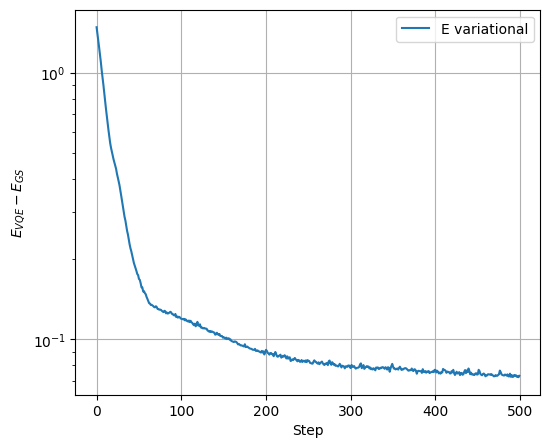

In [39]:
fig, ax = plt.subplots(1,figsize=[6.0,5.0],sharex=True)
e_tot_ref = E_gs


mean_e = np.asarray([np.real(energy.mean) for energy in e_vec])
err_e  = np.asarray([np.real(energy.error_of_mean) for energy in e_vec])
var_e  = np.asarray([np.real(energy.variance) for energy in e_vec])

n_opt  = list(range(len(mean_e)))



## Plot energy with error
ax.errorbar(n_opt,mean_e-e_tot_ref,label="E variational",color="C0")

ax.set_xlabel("Step")
ax.set_ylabel(r"$E_{VQE}-E_{GS}$")
ax.legend()
ax.grid()
ax.set_yscale("log")

fig.subplots_adjust(hspace=0.04)
plt.show()